In [160]:
#Import libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import seaborn as sns
import statsmodels.api as sm

In [161]:
#load in our dataset
df = pd.read_csv("Resources/mountain_pastured_cows.csv")
display(df.head())

,newid,lact_num,calv_date,alp_date,avg_milk,avg_thi3,avg_csi3,avg_thi30,avg_csi30,avg_precspring
0,224364,5,2010-02-19,2010-06-05,26.20,60.17,966.13,54.81,1038.28,134.61
1,83453,5,2001-11-09,2002-06-15,12.20,66.08,917.76,54.56,1111.54,184.40
2,261565,3,2000-09-16,2001-06-24,14.60,66.78,899.06,61.77,1000.32,184.08
3,122783,5,2008-10-18,2009-06-29,15.17,63.49,1053.80,62.35,1037.26,116.96
4,252570,1,2007-09-14,2008-06-02,12.03,65.96,969.90,61.04,998.60,154.72


### Data Exploration

In [162]:
#check dtypes
df.dtypes

newid               int64
lact_num            int64
calv_date          object
alp_date           object
avg_milk          float64
avg_thi3          float64
avg_csi3          float64
avg_thi30         float64
avg_csi30         float64
avg_precspring    float64
dtype: object

In [163]:
#check for nulls, negligible amount, should be clear to dropna
print(df.isna().sum()/len(df))
print(df.shape)

newid             0.00000
lact_num          0.00000
calv_date         0.00000
alp_date          0.00000
avg_milk          0.00000
avg_thi3          0.00205
avg_csi3          0.00205
avg_thi30         0.00205
avg_csi30         0.00205
avg_precspring    0.00000
dtype: float64
(20000, 10)


In [164]:
df = df.dropna()
print(df.shape)

(19959, 10)


### Feature Engineering

In [165]:
# Example: converting 'calv_date' and 'alp_date' columns to datetime
df['calv_date'] = pd.to_datetime(df['calv_date'])
df['alp_date'] = pd.to_datetime(df['alp_date'])

display(df.head())
print(df.dtypes)


,newid,lact_num,calv_date,alp_date,avg_milk,avg_thi3,avg_csi3,avg_thi30,avg_csi30,avg_precspring
0,224364,5,2010-02-19,2010-06-05,26.20,60.17,966.13,54.81,1038.28,134.61
1,83453,5,2001-11-09,2002-06-15,12.20,66.08,917.76,54.56,1111.54,184.40
2,261565,3,2000-09-16,2001-06-24,14.60,66.78,899.06,61.77,1000.32,184.08
3,122783,5,2008-10-18,2009-06-29,15.17,63.49,1053.80,62.35,1037.26,116.96
4,252570,1,2007-09-14,2008-06-02,12.03,65.96,969.90,61.04,998.60,154.72


newid                      int64
lact_num                   int64
calv_date         datetime64[ns]
alp_date          datetime64[ns]
avg_milk                 float64
avg_thi3                 float64
avg_csi3                 float64
avg_thi30                float64
avg_csi30                float64
avg_precspring           float64
dtype: object


In [166]:
# Calculate the difference
df['date_diff'] = (df['alp_date'] - df['calv_date']).dt.days

df.head()

,newid,lact_num,calv_date,alp_date,avg_milk,avg_thi3,avg_csi3,avg_thi30,avg_csi30,avg_precspring,date_diff
0,224364,5,2010-02-19,2010-06-05,26.20,60.17,966.13,54.81,1038.28,134.61,106
1,83453,5,2001-11-09,2002-06-15,12.20,66.08,917.76,54.56,1111.54,184.40,218
2,261565,3,2000-09-16,2001-06-24,14.60,66.78,899.06,61.77,1000.32,184.08,281
3,122783,5,2008-10-18,2009-06-29,15.17,63.49,1053.80,62.35,1037.26,116.96,254
4,252570,1,2007-09-14,2008-06-02,12.03,65.96,969.90,61.04,998.60,154.72,262


In [167]:
#Replace datetime columns with numerical

# df['calv_year'] = df['calv_date'].dt.year | causes multicollinearity issues
df['calv_month'] = df['calv_date'].dt.month
df['calv_day_of_month'] = df['calv_date'].dt.day

# df['alp_year'] = df['alp_date'].dt.year | causes multicollinearity issues
df['alp_month'] = df['alp_date'].dt.month
df['alp_day_of_month'] = df['alp_date'].dt.day

df.head()

,newid,lact_num,calv_date,alp_date,avg_milk,avg_thi3,avg_csi3,avg_thi30,avg_csi30,avg_precspring,date_diff,calv_month,calv_day_of_month,alp_month,alp_day_of_month
0,224364,5,2010-02-19,2010-06-05,26.20,60.17,966.13,54.81,1038.28,134.61,106,2,19,6,5
1,83453,5,2001-11-09,2002-06-15,12.20,66.08,917.76,54.56,1111.54,184.40,218,11,9,6,15
2,261565,3,2000-09-16,2001-06-24,14.60,66.78,899.06,61.77,1000.32,184.08,281,9,16,6,24
3,122783,5,2008-10-18,2009-06-29,15.17,63.49,1053.80,62.35,1037.26,116.96,254,10,18,6,29
4,252570,1,2007-09-14,2008-06-02,12.03,65.96,969.90,61.04,998.60,154.72,262,9,14,6,2


In [168]:
df.dtypes

newid                         int64
lact_num                      int64
calv_date            datetime64[ns]
alp_date             datetime64[ns]
avg_milk                    float64
avg_thi3                    float64
avg_csi3                    float64
avg_thi30                   float64
avg_csi30                   float64
avg_precspring              float64
date_diff                     int64
calv_month                    int32
calv_day_of_month             int32
alp_month                     int32
alp_day_of_month              int32
dtype: object

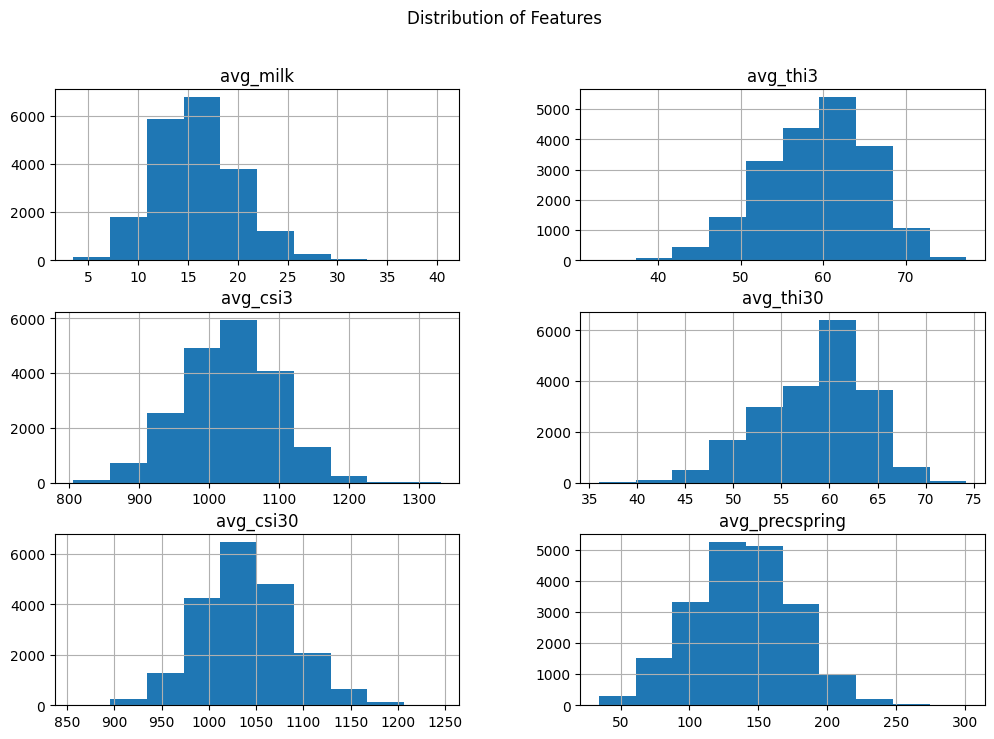

In [169]:
# Visualize distributions of numeric columns
numeric_columns = ['avg_milk', 'avg_thi3', 'avg_csi3', 'avg_thi30', 'avg_csi30', 'avg_precspring']
df[numeric_columns].hist(figsize=(12, 8))
plt.suptitle("Distribution of Features")
plt.show()

## Preporccessing Data

### Data Leakage 

In [171]:
df.columns

Index(['newid', 'lact_num', 'calv_date', 'alp_date', 'avg_milk', 'avg_thi3',
       'avg_csi3', 'avg_thi30', 'avg_csi30', 'avg_precspring', 'date_diff',
       'calv_month', 'calv_day_of_month', 'alp_month', 'alp_day_of_month'],
      dtype='object')

In [172]:
features = ['lact_num', 'avg_milk', 'avg_thi3', 'avg_csi3', 'avg_csi30',
       'avg_precspring', 'date_diff', 'calv_month',
       'calv_day_of_month', 'alp_month', 'alp_day_of_month']

# Calculate VIF
X = df[features]
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [vif(X.values, i) for i in range(X.shape[1])]

print(vif_data)

              Feature          VIF
0               const  4350.541432
1            lact_num     1.093165
2            avg_milk     1.583383
3            avg_thi3     6.963646
4            avg_csi3     3.926807
5           avg_csi30     2.587901
6      avg_precspring     1.268668
7           date_diff     2.117705
8          calv_month     2.834302
9   calv_day_of_month     1.015470
10          alp_month     1.502374
11   alp_day_of_month     1.388929


In [173]:
# remove problematic or no longer needed columns
df = df.drop(["newid",'avg_thi30', 'calv_date', 'alp_date'], axis = 1)
df.head()

,lact_num,avg_milk,avg_thi3,avg_csi3,avg_csi30,avg_precspring,date_diff,calv_month,calv_day_of_month,alp_month,alp_day_of_month
0,5,26.20,60.17,966.13,1038.28,134.61,106,2,19,6,5
1,5,12.20,66.08,917.76,1111.54,184.40,218,11,9,6,15
2,3,14.60,66.78,899.06,1000.32,184.08,281,9,16,6,24
3,5,15.17,63.49,1053.80,1037.26,116.96,254,10,18,6,29
4,1,12.03,65.96,969.90,998.60,154.72,262,9,14,6,2


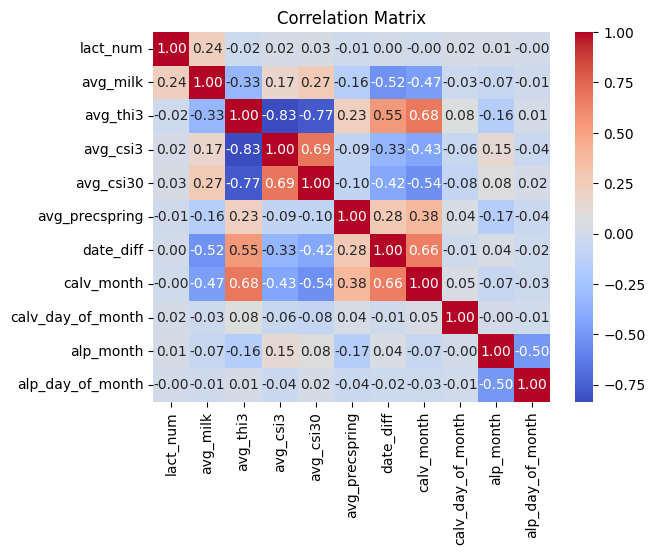

In [174]:
corr_matrix = df[features].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()